<a href="https://colab.research.google.com/github/grishabh147/DecFocSurrMod/blob/test/rate_law_nn_bigM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install omlt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import omlt

In [5]:
from omlt import OmltBlock, OffsetScaling
from omlt.io import load_keras_sequential
from omlt.neuralnet import FullSpaceSmoothNNFormulation
import pyomo.environ as pyo
import pandas as pd
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [6]:
columns = ['A_0', 'R_0', 'T_0', 'r']
df = pd.read_csv('training_data.csv', usecols=columns)
print(df)

             A_0       R_0         T_0         r
0       0.481781  0.577824  433.309916  0.006072
1       0.151756  0.206588  475.272574 -0.007004
2       0.111623  0.187235  485.490899 -0.015498
3       0.171848  0.887662  429.975677 -0.013962
4       0.282865  0.909169  477.283284 -0.085640
...          ...       ...         ...       ...
269995  1.922550  0.691538  452.739812  0.103291
269996  1.586375  0.762542  496.043536  0.123812
269997  1.286044  1.872642  414.672415  0.011228
269998  1.354142  1.352000  460.975511  0.018369
269999  1.930522  1.867995  492.602445 -0.060032

[270000 rows x 4 columns]


In [7]:
inputs = ['A_0', 'R_0', 'T_0']
outputs = ['r']
dfin = df[inputs]
# dfin = dfin.sample(n = 10000)
dfout = df[outputs]
# dfout = dfout.sample(n = 10000)

In [8]:
x_offset, x_factor = dfin.mean().to_dict(), dfin.std().to_dict()
y_offset, y_factor = dfout.mean().to_dict(), dfout.std().to_dict()

dfin = (dfin - dfin.mean()).divide(dfin.std())
dfout = (dfout - dfout.mean()).divide(dfout.std())

# capture the minimum and maximum values of the scaled inputs
# so we don't use the model outside the valid range
scaled_lb = dfin.min()[inputs].values
scaled_ub = dfin.max()[inputs].values

In [9]:
# create our Keras Sequential model
nn = Sequential(name='reformer_relu_4_20')
nn.add(Dense(units=10, input_dim=len(inputs), activation='relu'))
nn.add(Dense(units=10, activation='relu'))
nn.add(Dense(units=10, activation='relu'))
nn.add(Dense(units=10, activation='relu'))
nn.add(Dense(units=len(outputs)))
nn.compile(optimizer=Adam(), loss='mse')

In [10]:
# train our model
n_train = 3000
x = dfin[:n_train].values
y = dfout[:n_train].values
x_test = dfin[n_train+1:n_train+101].values
y_test = dfout[n_train+1:n_train+101].values
print(x.shape)
history = nn.fit(x, y, epochs=1500, validation_split=0.2)

(3000, 3)
Epoch 1/1500
75/75 [==============================] - 2s 11ms/step - loss: 0.6427 - val_loss: 0.4747
Epoch 2/1500
75/75 [==============================] - 1s 7ms/step - loss: 0.2734 - val_loss: 0.1809
Epoch 3/1500
75/75 [==============================] - 1s 7ms/step - loss: 0.1223 - val_loss: 0.0929
Epoch 4/1500
75/75 [==============================] - 1s 8ms/step - loss: 0.0642 - val_loss: 0.0558
Epoch 5/1500
75/75 [==============================] - 1s 8ms/step - loss: 0.0450 - val_loss: 0.0396
Epoch 6/1500
75/75 [==============================] - 1s 11ms/step - loss: 0.0354 - val_loss: 0.0319
Epoch 7/1500
75/75 [==============================] - 1s 9ms/step - loss: 0.0295 - val_loss: 0.0270
Epoch 8/1500
75/75 [==============================] - 1s 8ms/step - loss: 0.0244 - val_loss: 0.0219
Epoch 9/1500
75/75 [==============================] - 1s 10ms/step - loss: 0.0213 - val_loss: 0.0192
Epoch 10/1500
75/75 [==============================] - 1s 8ms/step - loss: 0.0180 - val

In [88]:
# number of parameters
import numpy as np
print(nn.trainable_variables)
np.sum([np.prod(v.shape) for v in nn.trainable_variables])

[<tf.Variable 'dense/kernel:0' shape=(3, 10) dtype=float32, numpy=
array([[-0.0070605 , -0.15554573, -0.377121  ,  0.20710541, -0.0586023 ,
         0.33261904,  0.24989001, -0.4828813 , -0.24666212,  0.35522097],
       [ 0.42674387,  0.33478504,  0.48531312,  0.4270279 , -0.03654071,
        -0.30086723,  0.27803954,  0.52466315,  0.24915339, -0.37071374],
       [ 0.5139345 , -0.47736487,  0.8385531 ,  0.3916967 ,  0.73989004,
        -0.24660152, -0.09144553,  0.07466475, -0.68197083,  0.6351974 ]],
      dtype=float32)>, <tf.Variable 'dense/bias:0' shape=(10,) dtype=float32, numpy=
array([-0.15214403,  0.32539502,  0.47690675, -0.48783612, -0.65333474,
        0.16569275,  0.41647616,  0.17462474,  0.41693783, -0.18725723],
      dtype=float32)>, <tf.Variable 'dense_1/kernel:0' shape=(10, 10) dtype=float32, numpy=
array([[ 1.65810689e-01,  2.75985301e-01, -2.76080459e-01,
         1.41795054e-01,  1.56979501e-01,  2.66900837e-01,
         5.11675000e-01, -7.22249389e-01,  3.662146

381

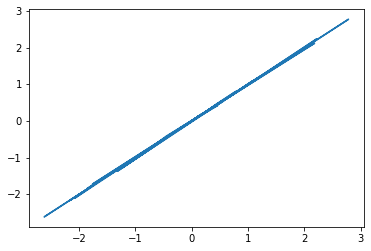

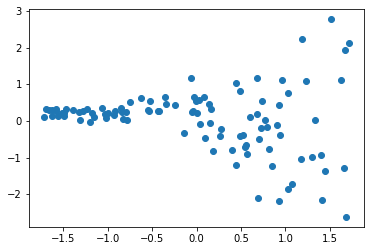

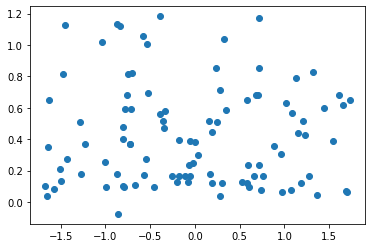

In [56]:
from tensorflow import GradientTape
from tensorflow import Variable
x_test = Variable(x_test)
with GradientTape() as tape:
  tape.watch(x_test)
  predictions = nn(x_test)
grads = tape.gradient(predictions, x_test)
from matplotlib import pyplot as plt
plt.figure(1)
plt.plot(y_test, predictions)
plt.figure(2)
plt.scatter(x_test[:, 2], predictions)
plt.figure(3)
plt.scatter(x_test[:, 1], grads[:, 0])

In [42]:
x_test[:, 1].shape

(100,)

In [14]:
# save the model to disk
# While not technically necessary, this shows how we can load a previously saved model into
# our optimization formulation)
nn.save('reformer_nn_relu')

In [26]:
!apt-get install -y -qq coinor-cbc
!wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64

unzip:  cannot find or open bonmin-linux64, bonmin-linux64.zip or bonmin-linux64.ZIP.


In [29]:
!wget -N -q "https://ampl.com/dl/open/bonmin/bonmin-linux64.zip"
!unzip -o -q bonmin-linux64

In [16]:
!wget -N -q "https://ampl.com/dl/open/couenne/couenne-linux64.zip"
!unzip -o -q couenne-linux64

In [93]:
!unzip -o -q /content/baron-lin64

In [113]:
import sys
print(sys.path)
sys.path.append('/content/baron-lin64/baron')
sys.path.append('/content/baron-lin64/baron/baronlice.txt')
print(sys.path)

['/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/baron-lin64', '/content/baron-lin64']
['/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/baron-lin64', '/content/baron-lin64', '/content/baron-lin64/baron', '/content/baron-lin64/baron/baronlice.txt']


In [114]:
# first, create the Pyomo model
m = pyo.ConcreteModel()
# create the OmltBlock to hold the neural network model
m.reformer = OmltBlock()

In [115]:
# load the Keras model
nn_reformer = keras.models.load_model('reformer_nn_relu', compile=False)

In [116]:
from omlt.neuralnet import ReluBigMFormulation
from omlt.neuralnet import ReluComplementarityFormulation
from omlt.neuralnet import ReluPartitionFormulation

In [117]:
# Note: The neural network is in the scaled space. We want access to the
# variables in the unscaled space. Therefore, we need to tell OMLT about the
# scaling factors
scaler = OffsetScaling(
        offset_inputs={i: x_offset[inputs[i]] for i in range(len(inputs))},
        factor_inputs={i: x_factor[inputs[i]] for i in range(len(inputs))},
        offset_outputs={i: y_offset[outputs[i]] for i in range(len(outputs))},
        factor_outputs={i: y_factor[outputs[i]] for i in range(len(outputs))}
    )

scaled_input_bounds = {i: (scaled_lb[i], scaled_ub[i]) for i in range(len(inputs))}

# create a network definition from the Keras model
net = load_keras_sequential(nn_reformer, scaling_object=scaler, scaled_input_bounds=scaled_input_bounds)

# create the variables and constraints for the neural network in Pyomo
m.reformer.build_formulation(ReluBigMFormulation(net))

In [118]:
tau = 60 # s
dH = -5000 # cal/mol
rho = 1.0 # kg/L
cp = 1000 # cal/kg.K
def opt_temp(Ai):
  A0_idx = inputs.index('A_0')
  R0_idx = inputs.index('R_0')
  T0_idx = inputs.index('T_0')
  r_idx = outputs.index('r')
  m.Ti = pyo.Var(domain=pyo.NonNegativeReals)
  
  # Objective
  m.cost = pyo.Objective(expr = 2.009*m.reformer.inputs[R0_idx] - 1.657*1e-3*(m.Ti - 410)**2, sense = pyo.maximize)

  # Constraints
  m.A_balance = pyo.Constraint(expr = 1/tau*(Ai - m.reformer.inputs[A0_idx]) - m.reformer.outputs[r_idx] == 0)
  m.R_balance = pyo.Constraint(expr = 1/tau*(0 - m.reformer.inputs[R0_idx]) + m.reformer.outputs[r_idx] == 0)
  m.energy = pyo.Constraint(expr = 1/tau*(m.Ti - m.reformer.inputs[T0_idx]) + (-dH/(rho*cp)*m.reformer.outputs[r_idx]) == 0)
  # m.pprint()
  solver = pyo.SolverFactory('baron', executable='/content/baron-lin64/baron').solve(m, tee=True).write()

  print('Ti = ', pyo.value(m.Ti()))

In [119]:
opt_temp(1.0)

 BARON version 22.9.30. Built: LNX-64 Fri Sep 30 09:06:37 EDT 2022

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 No BARON license file found in user PATH.  Continuing in demo mode.
 Model exceeds demo size (10 variables, 10 constraints, 50 nonlinearities)
 A valid BARON license is required for this model.
 BARON will exit now.

                          *** Licensing error ***             

 All done


ValueError: ignored

In [104]:
# Test feasible region
def feas_region(Ai, Ti):
  A0_idx = inputs.index('A_0')
  R0_idx = inputs.index('R_0')
  T0_idx = inputs.index('T_0')
  r_idx = outputs.index('r')
  # m.Ti = pyo.Var(domain=pyo.NonNegativeReals)
  
  # Objective
  m.cost = pyo.Objective(expr = 0, sense = pyo.maximize)

  # Constraints
  m.A_balance = pyo.Constraint(expr = 1/tau*(Ai - m.reformer.inputs[A0_idx]) - m.reformer.outputs[r_idx] == 0)
  m.R_balance = pyo.Constraint(expr = 1/tau*(0 - m.reformer.inputs[R0_idx]) + m.reformer.outputs[r_idx] == 0)
  m.energy = pyo.Constraint(expr = 1/tau*(Ti - m.reformer.inputs[T0_idx]) + (-dH/(rho*cp)*m.reformer.outputs[r_idx]) == 0)
  # m.pprint()
  solver = pyo.SolverFactory('cbc', executable='/usr/bin/cbc').solve(m, tee=True).write()
  return pyo.value(m.reformer.inputs[R0_idx])

In [105]:
Ai = 1
R0 = []
for Ti in range(400, 520, 2):
  opt_R0 = feas_region(Ai, Ti)
  R0.append(opt_R0)

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Welcome to the CBC MILP Solver 
Version: 2.9.9 
Build Date: Aug 21 2017 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmp1j3gost3.pyomo.lp -stat=1 -solve -solu /tmp/tmp1j3gost3.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
 CoinLpIO::readLp(): Maximization problem reformulated as minimization
Presolve 146 (-68) rows, 111 (-23) columns and 611 (-115) elements
Statistics for presolved model
Original problem has 40 integers (40 of which binary)
Presolved problem has 40 integers (40 of which binary)
==== 111 zero objective 1 different
111 variables have objective of 0
==== absolute objective values 1 different
111 variables have objective of 0
==== for integers 40 zero objective 1 different
40 variables have objective of 0
==== for integers absolute objective values 1 different
40 variables have objective of 0
===== end objective counts


Problem has 146 rows, 111 columns (0 with objective) and 611 elements
Column breakdown:
0 of ty

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 146
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.07
  Wallclock time: 0.08
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 146
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.09
  Wallclock time: 0.09
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 146
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.1
  Wallclock time: 0.12
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 146
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.08
  Wallclock time: 0.08
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 146
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.07
  Wallclock time: 0.07
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 146
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.08
  Wallclock time: 0.07
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 146
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.04
  Wallclock time: 0.04
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 146
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.1
  Wallclock time: 0.1
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 147
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.09
  Wallclock time: 0.11
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 147
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.07
  Wallclock time: 0.08
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 147
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.1
  Wallclock time: 0.11
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 147
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.16
  Wallclock time: 0.16
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 147
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.04
  Wallclock time: 0.05
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 147
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.08
  Wallclock time: 0.08
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 147
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.14
  Wallclock time: 0.14
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 147
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.05
  Wallclock time: 0.05
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 147
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.15
  Wallclock time: 0.16
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 147
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.04
  Wallclock time: 0.04
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 148
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.06
  Wallclock time: 0.08
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 148
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.05
  Wallclock time: 0.05
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 148
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.08
  Wallclock time: 0.08
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 148
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.88
  Wallclock time: 0.95
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 147
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.11
  Wallclock time: 0.11
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 147
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.1
  Wallclock time: 0.1
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 147
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.08
  Wallclock time: 0.09
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 147
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.15
  Wallclock time: 0.17
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Welcome to the CBC MILP Solver 
Version: 2.9.9 
Build Date: Aug 21 2017 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpffz6k8q3.pyomo.lp -stat=1 -solve -solu /tmp/tmpffz6k8q3.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
 CoinLpIO::readLp(): Maximization problem reformulated as minimization
Presolve 147 (-67) rows, 111 (-23) columns and 613 (-113) elements
Statistics for presolved model
Original problem has 40 integers (40 of which binary)
Presolved problem has 40 integers (40 of which binary)
==== 111 zero objective 1 different
111 variables have objective of 0
==== absolute objective values 1 different
111 variables have objective of 0
==== for integers 40 zero objective 1 different
40 variables have objective of 0
==== for integers absolute objective values 1 different
40 variables have objective of 0
===== end objective counts


Problem has 147 rows, 111 columns (0 with objective) and 613 elements
Column breakdown:
0 of ty

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 147
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.1
  Wallclock time: 0.12
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 147
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.05
  Wallclock time: 0.05
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 147
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.11
  Wallclock time: 0.12
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 147
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.12
  Wallclock time: 0.13
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 147
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.86
  Wallclock time: 0.9
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 147
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.07
  Wallclock time: 0.07
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 147
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.06
  Wallclock time: 0.07
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 147
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.1
  Wallclock time: 0.11
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 147
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.04
  Wallclock time: 0.05
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 148
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.06
  Wallclock time: 0.06
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 148
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.97
  Wallclock time: 1.02
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 148
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.06
  Wallclock time: 0.06
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 148
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.06
  Wallclock time: 0.07
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 148
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.04
  Wallclock time: 0.05
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 148
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.05
  Wallclock time: 0.06
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 149
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.06
  Wallclock time: 0.06
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 149
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.06
  Wallclock time: 0.08
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 149
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.06
  Wallclock time: 0.13
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 149
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.07
  Wallclock time: 0.15
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: -0.0
  Upper bound: -0.0
  Number of objectives: 1
  Number of constraints: 149
  Number of variables: 111
  Number of binary variables: 40
  Number of integer variables: 40
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.05
  Wallclock time: 0.12
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound:

KeyboardInterrupt: ignored

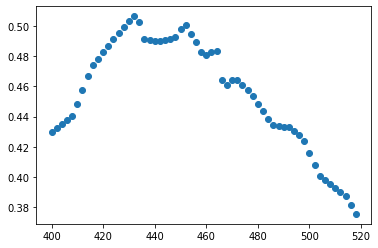

In [82]:
plt.figure()
plt.scatter(range(400,520,2), R0)